# CSE 204 Lab 13: Reinforcement Learning II

Jesse Read, J.B. Scoggins

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jbscoggi/teaching/blob/master/Polytechnique/CSE204/Lab13_answers.ipynb) 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jbscoggi/teaching/master?filepath=Polytechnique%2FCSE204%2FLab13_answers.ipynb)

## Introduction

This is the second lab dealing with reinforcement learning.  Today, the goal will be to implement and train an agent to balance a pole on top of a moveable cart using the hill climbing algorithm discussed in the lecture.  We will again use the [OpenAI Gym](https://gym.openai.com) library that you saw in the last lab for creating the environment for our agent to act in.  To get started, import the necessary packages.

In [1]:
import numpy as np
from numpy.random import choice as sample
from numpy.random import rand, randn

import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'gym'

Before proceeding with the excercise, you can run the following cell to see the cart-pole problem in action with an agent that takes random actions at each time step.

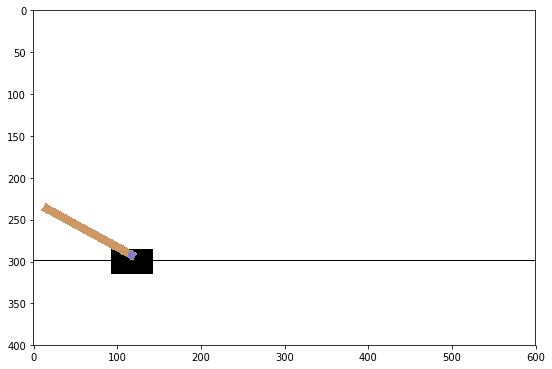

In [2]:
env = gym.make('CartPole-v1')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

Unless you got very lucky, you will notice that the pole on top of the cart fell and possibly spun around the cart several times.  In fact, this problem is physically unstable, and without a proper controller, the pole will always fall.  In order to stop the pole from falling, the agent is given two possible actions: 1) apply a positive force +1 or 2) apply a negative force -1.  The response to this force depends on the friction of the cart on the track, and the pole on the cart, the mass of both the cart and the pole, and the horizontal and angular velocities and the cart and pole respectively.  At any given point in time, the state of the system is fully characterized by 4 variables:

1. The horizontal location of the cart
2. The horizontal velocity of the cart
3. The angular position of the pole
4. The angular velocity of the pole

Given those four quantities and the force imposed on the cart, the system behavior is governed by a set of differential equations, which are hidden from you and the agent.  Your task therefore, is to build an agent which learns from the response of the cart-pole system to various force inputs, such that it can create a policy for balancing the pole.

## Hill Climbing

As you may recall, hill climbing is a simple but powerful learning technique.  Here is a quick refresher if you don't remember the details.  First, let's recall a bit of the terminology.

1. We have an environment (in this case the cart-pole problem).
2. An agent maps observations of the state of the environment $\mathcal{S}$ to allowed actions $\mathcal{A}$ through a policy $\pi : \mathcal{S} \mapsto \mathcal{A}$.
3. A reward function provides a metric to measure the benifit of taking an action for a given state.
4. Ideally, the best policy is one that maximizes the return, which is the sum of the rewards for a series of actions over a finite amount of time.
5. A value function maps a given state to the expected return given the best policy.

In this lab, we will work with policy learning, which means that we will search for the best policy that maximizes the return value.  Specifically, we consider policies of the form

$$ a_t = \pi_\theta(s_t) = \text{argmax} \;\sigma(W^T s_t + b) $$

where $a_t$ is the action at time $t$, given the policy and state at time $t$.  The policy parameters $\theta = \{W, b\}$ represent the weights and biases for the linear transformation of the state space into action space, and $\sigma$ is a nonlinear operator, such as the sigmoid function.  Note this is just a single layer perceptron, like the ones you have dealt with in previous labs on neural networks.  The difference here, however, is that we will not train this network with gradient descent, but rather with the hill climbing algorithm, which is summarized as follows.

---
**Algorithm 1: Random Optimization in Continuous Search Space (Hill Climbing)**
1. Initialize weights and biases, $\theta$
2. Select minimal return desired, $g_{\text{min}}$.
3. Loop while $g(\theta) < g_{\text{min}}$
   1. Sample nearby parameters, $\theta' \sim N(\theta, \sigma^2)$
   2. if $g(\theta') > g(\theta)$:
      1. Update parameters, $\theta \gets \theta'$
---


## Part 1: Implement policy function

**Exercise 1.1**: Fill in the code below to implement the SLP policy function.

In [3]:
def linear(a):
    '''Linear activation.'''
    return a

def sigmoid(a):
    '''Sigmoid activation.'''
    return 1.0 / (1.0 + np.exp(-a))

class SLP():
    '''A Single-Layer Perceptron with copy and random modification.'''

    def __init__(self, inputs, outputs, activation = linear):
        self.input_size = inputs
        self.output_size = outputs
        self.reset()
        self.activation = activation

    def reset(self, scaling=0.0):
        '''Resets the weights and biases to normal distribution with scaling.'''
        self.W = scaling * randn(self.input_size,self.output_size)
        self.b = scaling * randn(self.output_size) # bias

    def predict(self,x):
        '''Feedforward prediction of SLP.'''
        a = np.dot(x,self.W) + self.b
        return self.activation(a)

    def copy(self, modify=False):
        '''Creates a copy of this SLP, with possible modification.'''
        
        # Create a copy
        b = SLP(self.input_size, self.output_size)
        b.W = self.W.copy()
        b.b = self.b.copy()

        if modify:
            b.modify()

        return b

    def modify(self, alpha_w=0.01, alpha_b=0.01, prob_reset=0.1):
        '''Adds perturbation to weights and biases, scaled by alphas, with random reset probability.'''

        if rand() < prob_reset:
            self.reset()

        # Make a random adjustment to the weight matrix.
        self.W = self.W + alpha_w * randn(*self.W.shape) 
        self.b = self.b + alpha_b * randn(*self.b.shape)

## Part 2: Implement the SimpleHillClimber Agent

In this part, we will implement a simple hill climber.  The agent has two functions, 1) update the policy given an observation and reward and 2) act on an observation (evaluate the policy).  To help get you started, the next cell has the code which we will use to place our agent in the environment.

In [5]:
def run_agent(env, agent, num_epsiodes = 50 , max_episode_length=200, render=False):

    R = 0 
    
    if render:
        plt.figure(figsize=(9,9))
        img = plt.imshow(env.render(mode='rgb_array')) # only call this once

    # For n episodes ...
    for i in range(num_epsiodes):

        s_t = env.reset()

        # For each time step ...
        for t in range(max_episode_length):

            # Draw
            if render:
                img.set_data(env.render(mode='rgb_array')) # just update the data
                display.display(plt.gcf())
                display.clear_output(wait=True)

            # Act
            a_t = agent.act(s_t)

            # Step
            s_t, r_t, done, info = env.step(a_t)

            # Update
            agent.update_policy(s_t, r_t, done)

            R = R + r_t
            if done:
                break
    
    env.close()

    return (1.0 / num_epsiodes) * R

The outer loop in the code above loops over the number of "episodes." An episode is a single simulation from beginning to end, starting from a clean environment.  The inner loop is looping over the maximum number of iterations in each episode.  Note that it is possible for the environment to decide that the episode is complete before the maximum iterations is reached.  This may happen if the cart or pole leave some bounded domain, for example.  A single iteration is controlled by 4 steps, as shown in the code:

1. Render the environment (optional)
2. Ask the agent for an action given the current state of the system (observation)
3. Simulate a single step in the environment (perform the action)
4. Allow the agent to update its policy

At the end of all the episodes, the function returns the average reward per episode.  Note that, for the cart and pole environment, rewards are either +1 when the pole does not fall below 15 degrees from vertical in a single step and zero otherwise.  Therefore, if we take 200 steps per episode, the best average reward we can obtain is 200.

**Exercise 2.1**: Implement the SimpleHillClimber class based on Algorithm 1.  The agent will keep track of two policies, 1) the best policy so far, and 2) a random perturbation from the best policy.  

At each call to update_policy, the agent will update the current return (sum of rewards) and total number of calls.  
If the end of an episode is reached, the current value of the return should be added to a "memory" vector, and return and number of iterations should be set back to zero.   
Once the number of episodes per test is reached, the agent should check if the average return per episode is improved over the current policy.  If it is, then the current policy is replaced by the trial policy.  Either way, a new trail policy should then be created using the modify function of the SLP policy and the memory vector should be reset to empty.

Whenever act is called, the current trial policy should be evaluated and returned.

In [4]:
class SimpleHillClimber():
    '''Simple Hill Climbing Agent'''

    def __init__(self, obs_space, act_space, max_episode_length=50, num_episodes_per_test=100, alpha=0.1):

        # Size of observation and action spaces
        D = obs_space.shape[0]
        L = act_space.n

        # Max length of an episode 
        self.T = max_episode_length
        # Step counter
        self.t = 0

        # Number of episodes per test
        self.num_episodes_per_test = num_episodes_per_test
        # Test counter
        self.i = 0
        # Test counter (successful ones; with an accept)
        self.i_success = 0
        # Return for the current episode
        self.R = 0 
        # Mean return per episode (best so far)
        self._avg_R = -100000
        # Store test result here
        self.memory = []

        # Alpha (step size / learning rate)
        self.alpha_init = alpha
        self.alpha = self.alpha_init
        self.alpha_decay = 1 # 0.99999

        self.policy = SLP(D,L,activation=sigmoid)
        self.policy_trial = self.policy.copy(modify=True)



    def update_policy(self,obs,reward,done=False):

        # Update the return for the episode
        self.R = self.R + reward

        # Counting (each step of the episode of max length T)
        self.t = self.t + 1

        # If end of epsiode ...
        if self.t >= self.T or done:

            # End of the episode 
            self.memory.append(self.R)
            # Reset
            self.t = 0
            self.R = 0
            self.alpha = self.alpha * self.alpha_decay

        # If end of the set of tests 
        if len(self.memory) >= self.num_episodes_per_test:

            # Calculate the average return per episode
            avg_R = sum(self.memory)/self.num_episodes_per_test
            self.i = self.i + 1

            if avg_R > self._avg_R:
                # Accept
                self._avg_R = avg_R
                self.policy = self.policy_trial.copy()
                self.i_success += 1
            else:
                # Reject (modify old policy)
                self.policy_trial = self.policy.copy()

            self.policy_trial.modify(alpha_w=self.alpha, alpha_b=self.alpha*0.1, prob_reset=0.01)

            # Reset
            self.memory = []
            

    def act(self,obs,reward=None,done=False):
        y = self.policy_trial.predict(obs)
        return np.argmax(y)

**Exercise 2.2**: Run the training loop below.  You should see the average reward increasing as the number of episodes increases.  Note, that since we are using a rather simple algorithm here, you may need to restart this a few times to get a good result.  If you have tried it 3-5 times with no improvement, then you may have a bug in your hill climber agent.

Episode 50, average return: 9.3
Episode 100, average return: 9.22
Episode 150, average return: 9.200000000000001
Episode 200, average return: 9.28
Episode 250, average return: 9.120000000000001
Episode 300, average return: 9.16
Episode 350, average return: 47.9
Episode 400, average return: 51.58
Episode 450, average return: 32.78
Episode 500, average return: 30.14
Episode 550, average return: 9.700000000000001
Episode 600, average return: 9.58
Episode 650, average return: 36.04
Episode 700, average return: 33.78
Episode 750, average return: 9.28
Episode 800, average return: 9.38
Episode 850, average return: 105.82000000000001
Episode 900, average return: 109.5
Episode 950, average return: 88.9
Episode 1000, average return: 94.62
Episode 1050, average return: 102.38
Episode 1100, average return: 115.2
Episode 1150, average return: 135.46
Episode 1200, average return: 121.24000000000001
Episode 1250, average return: 114.06
Episode 1300, average return: 102.56
Episode 1350, average return

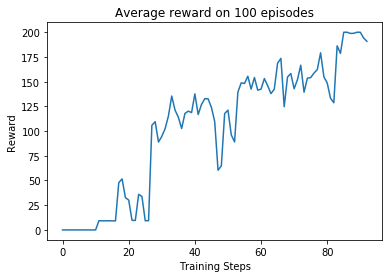

In [23]:
env = gym.make("CartPole-v0")
env.reset()
agent = SimpleHillClimber(
    env.observation_space, env.action_space, 
    max_episode_length=200, num_episodes_per_test=100, alpha=0.1)

t = 0
average_returns = [0,0,0,0,0,0,0,0,0,0,0]
while np.min(average_returns[-10:-1]) < 150:

    # Run the agent in the environment
    R = run_agent(env, agent, render=False)

    # Monitoring
    average_returns.append(R)
    t += 1

    print("Episode {0}, average return: {1}".format(t*50, R))

plt.plot(range(len(average_returns)),average_returns)
plt.title("Average reward on 100 episodes")
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.show()

**Exercise 2.3**: Run the agent for a single episode to see an animation of your trained agent.

200.0


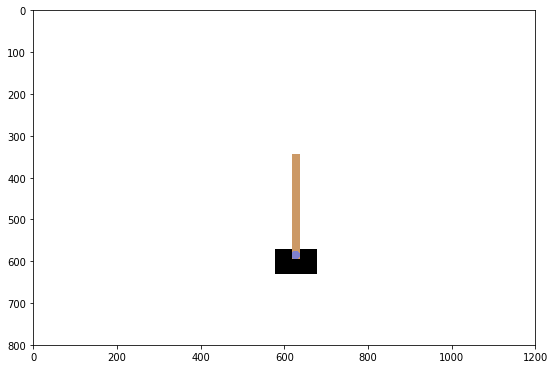

In [27]:
# Finished, show animation; training curve
R = run_agent(env, agent, num_epsiodes=1, render=True)
print(R)


## Going further

There are a number of improvements that you can make to the simple hill climber we made here.  For example, you can use simulated annealing or beam search which you saw in the last lecture.  If you have time, consider adding one or more of these improvements.  Finally, the agent and code we created above is completely general.  Therefore you can try running on other environments.  For a complete list, look [here](https://gym.openai.com/docs/#available-environments).